# Preprocessing and Scaling

## The importance of scaling

We saw in chapter TODO that the breast cancer dataset contains features with many different magnitudes:

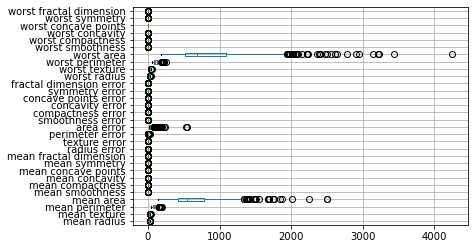

In [1]:
from sklearn.datasets import load_breast_cancer
# specifying "as_frame=True" returns the data as a dataframe in addition to a numpy array
cancer = load_breast_cancer(as_frame=True)
cancer_df = cancer.frame
cancer_features = cancer_df.drop(columns='target')
cancer_features.boxplot(vert=False)

When we applied the Nearest Neighbors algorithm in the previous chapter, we didn't pay any mind to that, and still got quite good results. Arguably, we just got lucky.
In fact, the scale of the data is tremendously important when using any distance based algorith, such as nearest neighbors, as the euclidean distance will but much larger emphasis on features that have larger magnitude.
This is illustrated in Figure TODO, which shows the features 'worst area' against 'worst concave points'. You can see that the x and y axis have vastly different scales. In fact, if we ``set_aspect('equal')`` we would only see a line (try it!).

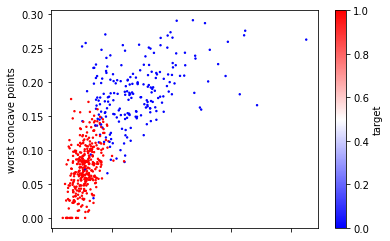

In [2]:
import matplotlib.pyplot as plt
ax = cancer_df.plot.scatter(x='worst area', y='worst concave points',
                            c='target', colormap='bwr', s=2)
#TODO xlabel?

Now if we apply 5-nearest neighbors on the data the way it is, the algorithm will basically ignore the y-axis, because distances on the y-axis are at most 0.3, while distances on the x-axis are in the hundreds or thousands.

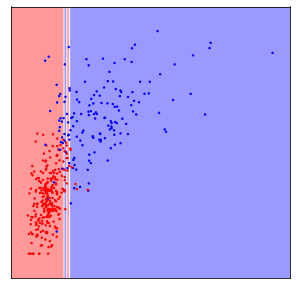

In [10]:
import sys
sys.path.append("..")
import numpy as np
from utils import plot_2d_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer_features, cancer_df.target, random_state=42)

fig, ax = plt.subplots(figsize=(5, 5))
clf = KNeighborsClassifier(n_neighbors=3).fit(X_train[['worst area', 'worst concave points']], y_train)
ax.scatter(X_train['worst area'], X_train['worst concave points'], c=y_train, cmap='bwr', s=2)
plot_2d_classification(clf, np.array(X_train[['worst area', 'worst concave points']]), ax=ax, alpha=.4, cmap='bwr', res=100)


This was probably not what we had in mind, and if we rescale the data, so that both features have a similar range (say between 0 and 1), the result is much different:

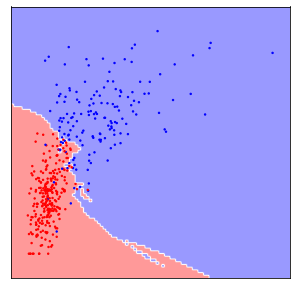

In [18]:
from sklearn.preprocessing import MinMaxScaler

fig, ax = plt.subplots(figsize=(5, 5))
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train[['worst area', 'worst concave points']])

clf = KNeighborsClassifier(n_neighbors=3).fit(X_train_scaled, y_train)
ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='bwr', s=2)
plot_2d_classification(clf, np.array(X_train_scaled), ax=ax, alpha=.4, cmap='bwr', res=100)

The difference between these two figures is simply whether the data was scaled to a common range or not, and clearly the outcome is dramatically different. The effect is not as large for all machine learning models, but many models do require scaling your data.

An example I think is illustrative of why this is important is when dealing with units. Imagine you have a dataset consisting of a persons height, and how far they live from their workplace. For each of these, you can pick a unit. Now say you picked cm (or inches) for both of them. Then the distance to their workplace would be a very large number, so without scaling, KNeighborsClassifier or any other distance-based algorithm would pay much more attention to it. Now say you decided it's strange to measure such long distances in cm (or inches), and you decide to use kilometers (or miles). Now, the height will have a larger magnitude than the distance to work, and a distance base algorithm will give more weight to that feature.
Clearly the unit you are choosing should not impact the machine learning model, and usually you don't a-priory have information about which features are important-that's what you want the model to figure out. Bringing all features on the same scale allows the model that, without biasing it in one direction or another in an arbitrary way.

Now let's look at some ways to scale your data with scikit-learn.


## Ways to Scale Data

There are several ways to scale your data, shown in figure TODO below.
Each of these methods is implemented in a Python class in scikit-learn.
One of the most common ways to scale data is to ensure the data has zero mean and unit variance after scaling (also known as standardization or sometimes z-scoring), which is implemented in the ``StandardScaler``.

![:scale 80%](images/scaler_comparison_scatter.png)



Let's have a look on how to use the StandardScaler on the breast cancer dataset. As with our classification models, we first import and instantiate the class:

In [35]:
from sklearn.preprocessing import StandardScaler
# While the standard scaler has some options,
# those are rarely used and we usually instantiate it with the default parameters:
scaler = StandardScaler()

Similar to fitting a model, we can fit our scaling to the data using the ``fit`` method on the training set. This simply estimates mean and standard deviation. You could think of scaling as a very simple unsupervised learning procedure, which certainly doesn't require the target ``y``, so it is enough to pass our feature ``X_train`` to the fit method:

In [37]:
scaler.fit(X_train)

StandardScaler()

Now, ``scaler`` has stored the mean and standard deviation of our data:

In [39]:
print(scaler.mean_)
print(scaler.scale_)

[1.41226643e+01 1.91988498e+01 9.18850235e+01 6.54919484e+02
 9.55561972e-02 1.02506714e-01 8.74703427e-02 4.77440869e-02
 1.80024413e-01 6.26067840e-02 4.02111737e-01 1.20767089e+00
 2.86367911e+00 4.01327254e+01 7.03638028e-03 2.53726854e-02
 3.22836148e-02 1.18490845e-02 2.04911479e-02 3.78268850e-03
 1.62118592e+01 2.55068779e+01 1.06886784e+02 8.73720657e+02
 1.31201831e-01 2.47729484e-01 2.67697533e-01 1.12653077e-01
 2.87796948e-01 8.33459390e-02]
[3.53058849e+00 4.22578613e+00 2.42759136e+01 3.56022552e+02
 1.39543507e-02 5.14081284e-02 7.85193143e-02 3.78165371e-02
 2.67869023e-02 7.21878787e-03 2.86199676e-01 5.43678655e-01
 2.09469043e+00 4.79685520e+01 3.09086708e-03 1.82308744e-02
 2.99782397e-02 6.27826746e-03 7.99741486e-03 2.68195906e-03
 4.77599313e+00 6.01990200e+00 3.30360621e+01 5.64580149e+02
 2.31962297e-02 1.49219846e-01 1.98739169e-01 6.43530007e-02
 6.15045058e-02 1.75602959e-02]


```{note}
Attributes that are estimated from the training data are named with trailing underscores, such as ``mean_`` in scikit-learn. This is to distinguish them for parameter that are passed to the model at instantiation time, such as ``n_neighbors`` in ``KNeighborsClassifier``.
```

To apply the scaling, we can use the ``transform`` method, which will subtract the mean and divide by the standard deviation:

In [41]:
X_train_scaled = scaler.transform(X_train)
print(X_train.shape)
print(X_train_scaled.shape)

(426, 30)
(426, 30)


It's important to note here that the return value of ``transform`` for any scikit-learn transformation is a numpy array, independent of whether the input ``X_train`` was a numpy array or a pandas DataFrame:

In [42]:
print(type(X_train))
print(type(X_train_scaled))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


This means we no longer have the column names associated with the data after scaling, though we can just take the column names from the input in this case, as scaling doesn't change the order of columns.
So if we prefer to have a dataframe again, we could create one like this:

In [44]:
# You can convert your data back to a dataframe after scaling, though that's usually not needed
# it can make plotting a bit easier, though.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

To illustrate the effect of scaling, let's look at the boxplot of the scaled data, and compare it to Figure TODO again:

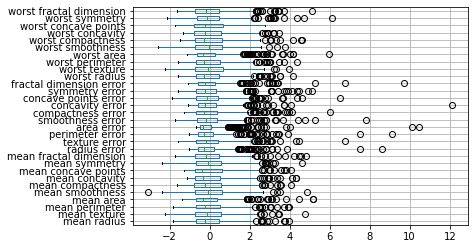

In [45]:
X_train_scaled_df.boxplot(vert=False)

````{note}
For many preprocessing operations such as scaling, it's very common to fit the model on the training dataset, and then transform the training datset.
As this is such a common pattern, there is a shortcut to do both of these at once, which will save you some typing, but might also allow a more efficient computation, and is called ``fit_transform``.
So we could equivalently write the above code as

```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
```

Another common patter, which uses the fact that ``fit`` returns the object itself, is this:

```python
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)``
```
However, this doesn't make use of potential computational shortcuts that are possible when computing ``fit`` and ``transform`` together in ``fit_transform``.

Scikit-learn guarantees that the output of ``.fit(X_train).transform(X_train)`` is the same as ```.fit_transform(X_train)`` up to numerical precision issues.

````

Another very common wayto scale data is to specify a common minimum and maximum for all features, which is implemented in ``MinMaxScaler``. The ``MinMaxScaler`` can scale to aribrary ranges, though the default of scaling to the range between 0 and 1 usually works just fine. Another common option is to scale between -1 and 1.
Figure TODO shows two more scalers, the ``RobustScaler`` and the ``Normalizer``. The ``RobustScaler`` works quite similar to the ``StandardScaler`` in that it shifts and scales each feature.
However, as opposed to using mean and variance like StandardScaler, the ``RobustScaler`` uses median and [interquartile ranges](https://en.wikipedia.org/wiki/Interquartile_range). In other words, ``StandardScaler`` ensures that the median of the data is zero, and that 50% of the samples is between -0.5 and 0.5 for each feature.

```{note}
It is called 'robust' because these measures are known as 'robust statistics', in that they are robust against the presence of outliers.
The mean and variance used in StandardScaler are not robust in that way: a single data point, if it's far enough away from the rest of the data, can have unlimited impact on mean and variance.
The same is not true for median and interquartile range, which are not impacted by single samples. In practice it might be a good idea to inspect your data and look for outliers and their meaning manually, and despite its better statistical properties, `RobustScaler` is used much less than `StandardScaler`.
```

Finally, there is also the ``Normalizer``, which is a bit of an odd one out in that it operates on each row independently, while all the other scalers operate on each column independently.
The normalizer divides each row by its length, either using euclidean distances (aka the L2 norm, using `norm='l2'`, the default) or by using the manhatten distance (aka the L1 norm, or sum of absolute values by using `norm='l1'`).
Both of these transformations can be seen as projecting all data points onto the unit ball, i.e. the circle with radius 1 (the circle with radius 1 in the l1 norm is a diamond).
For the L2 norm, this means normalizing away the length of the vector, and only keeping the direction. For the L1 norm, this has a very intuitive interpretation if all numbers are positive: it keeps the relative proportions, while discarding the overall sum. Both of these normalizations are often used with count data, as in the following example:
Assume each row corresponds a visitor that frequents a shopping mall, and each column corresponds to the different shops they are visiting:

In [33]:
import pandas as pd
shoppers = pd.DataFrame({'groceries': [0, 20, 10], 'fashion': [10, 200, 0], 'hardware': [2, 0, 3]})
shoppers

,groceries,fashion,hardware
0,0,10,2
1,20,200,0
2,10,0,3


Looking at distances in the original space, Shopper 0 is most similar to Shopper 2, as the counts are most similar. However, it might make more sense to have Shopper 0 be more similar to Shopper 2, as the both mostly show for fashion.
the Normalizer accomplishes that by normalizing by the total number of visits (when using the l1 distance):

In [30]:
Normalizer(norm='l1').fit_transform(shoppers)

array([[0.        , 0.83333333, 0.16666667],
       [0.09090909, 0.90909091, 0.        ],
       [0.76923077, 0.        , 0.23076923]])

However, overall, using the ``Normalizer`` is used much less common than using the ``StandardScaler`` or ``MinMaxScaler``.


## Scaling the test data
So far, we have only scaled the training data. To apply our model to any new data, including the test set, we clearly need to scale that data as well.
To apply the scaling to any other data, simply call ``transform``:

In [46]:
X_test_scaled = scaler.transform(X_test)

What this does is that it subtracts the *training set mean* and divides by the *training set standard deviation*. In other words, it doesn't compute these statistics for the test set, but it uses the statistics computed on the training set when calling ``fit``. This difference is critically important as illustrated in Figure TODO, which shows a two-dimensional dataset. Here, training data is shown in blue and test data is shown in red.
We apply a ``MinMaxScaler`` to the data, which results in the minimum and maximum on the training set being exactly 0 and 1 respectively, for each of the features. I.e. the blue points have minimum and maximum values of 0 and 1.
Then, we applied the same scaling to achieve these values to the test set. As a result, Figure TODO b) looks exactly the same as Figure TODO a), with the only difference being the tick marks.
Note how the minimum and maximum on the test set are not 0 and 1 in this figure.

Now, imagine we treated the test set in the same way we treated the training set, i.e. if we would call ``fit_transform`` on it and re-estimate the scale of the data.
That would lead to the test data being scaled in a way that the minimum and maximum are 0 and 1 respectively for each feature, as shown in Figure TODO c). Not that now the figure looks different, and the position of the red points has changed when relating them to the blue points. A model trained on the blue data can now no longer be applied to the red data, as the red data was transformed in a different way.

To summarize, **only ever fit any model or transformation on the training data, never call ``fit`` or ``fit_transform`` on the  test data.**

```{note}
Some people prefer to scale the data before splitting it into training and test set. While that might sometimes simplify the code, I would recommend against it.
Your goal will be to apply the model in production to new data, and you want your test data to stand in for this new data that you haven't observed yet. However, this new data will not be part of the set you use to compute your rescaling. If you included your test data in the scaling, that means that your new data is treated differently from the training set, which defeats the purpose of the training set.
In practice, this is unlikely to have a large impact, as computing mean and standard deviation is relatively stable on well-behaved datasets. However, I recommend to adhere to best practices, and split off the test set before doing *any* processing.
```

![:scale 100%](images/no_separate_scaling.png)


### KNN with Scaling on Breast Cancer data

Now, let's recap the whole process of scaling a dataset and then using it in Nearest Neighbors classification:

In [54]:
from sklearn.datasets import load_breast_cancer
# load the data, split off the target
cancer = load_breast_cancer(as_frame=True)
cancer_df = cancer.frame
cancer_features = cancer_df.drop(columns='target')
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(cancer_features, cancer_df.target, random_state=23)

# For comparison, run KNN again without scaling:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("accuracy without scaling: ", knn.score(X_test, y_test))

# Scale the training data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Fit a knn model on the scaled data
knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)

# Scale the test data
X_test_scaled = scaler.transform(X_test)
print("accuracy with scaling: ", knn_scaled.score(X_test_scaled, y_test))


accuracy without scaling:  0.9300699300699301
accuracy with scaling:  0.986013986013986


We can see that we could improve our model quite a bit simply by scaling the data!

## Picking the right scaler
We already discussed how the scalers differ a bit above. I think it's a relatively save default to use ``StandardScaler`` after doing some exploratory analysis.
However, if there is very clear minimum and maximum values, then a ``MinMaxScaler`` might be more appropriate. For example if your feature is a 10 point likert scale, at ``MinMaxScaler`` might be more natural than a ``StandardScaler``.
Similarly, when looking at image intensities that are often between 0 and 255, a ``MinMaxScaler`` seem more natural.
On the other hand, if your data looks more Gaussian distributed, or even has long tails, using the ``MinMaxScaler`` seems like a bad idea, as changing the split of the data can easily change the position of the maximum:

(array([9., 1., 1., 3., 0., 6.]),
 array([-1.01613112, -0.61158548, -0.20703985,  0.19750578,  0.60205142,
         1.00659705,  1.41114268]),
 <a list of 6 Patch objects>)

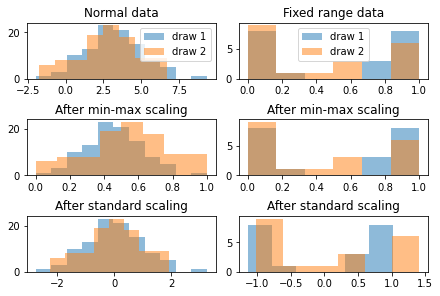

In [87]:
# Generate a numpy random state with a fixed seed
rs = np.random.RandomState(23)
# generate 100 normally distributed values
normal1 = rs.normal(loc=3, scale=2, size=(100, 1))
# another 100 normally distributed values
normal2 = rs.normal(loc=3, scale=2, size=(100, 1))

# scale the first normal dataset
normal1_mm = MinMaxScaler().fit_transform(normal1)
normal1_ss = StandardScaler().fit_transform(normal1)

# scale the second normal dataset
normal2_mm = MinMaxScaler().fit_transform(normal2)
normal2_ss = StandardScaler().fit_transform(normal2)

# constrained_layout ensures there is no overlapping figures and ticks
# similar to plt.tight_layout() but better
fig, axes = plt.subplots(3, 2, constrained_layout=True)
axes[0, 0].set_title('Normal data')
axes[0, 0].hist(normal1, bins='auto', alpha=.5, label='draw 1')
axes[0, 0].hist(normal2, bins='auto', alpha=.5, label='draw 2')
axes[0, 0].legend()

axes[1, 0].set_title('After min-max scaling')
axes[1, 0].hist(normal1_mm, bins='auto', alpha=.5)
axes[1, 0].hist(normal2_mm, bins='auto', alpha=.5)

axes[2, 0].set_title('After standard scaling')
axes[2, 0].hist(normal1_ss, bins='auto', alpha=.5)
axes[2, 0].hist(normal2_ss, bins='auto', alpha=.5)

# Sample from a dataset with a fixed minimum and maximum value
# in this case we use beta-distributed data

uniform1 = rs.beta(.1, .1, size=(20, 1))
uniform2 = rs.beta(.1, .1, size=(20, 1))

# scale the first uniform dataset
uniform1_mm = MinMaxScaler().fit_transform(uniform1)
uniform1_ss = StandardScaler().fit_transform(uniform1)

# scale the second uniform dataset
uniform2_mm = MinMaxScaler().fit_transform(uniform2)
uniform2_ss = StandardScaler().fit_transform(uniform2)

axes[0, 1].set_title('Fixed range data')
axes[0, 1].hist(uniform1, bins='auto', alpha=.5, label='draw 1')
axes[0, 1].hist(uniform2, bins='auto', alpha=.5, label='draw 2')
axes[0, 1].legend()

axes[1, 1].set_title('After min-max scaling')
axes[1, 1].hist(uniform1_mm, bins='auto', alpha=.5)
axes[1, 1].hist(uniform2_mm, bins='auto', alpha=.5)

axes[2, 1].set_title('After standard scaling')
axes[2, 1].hist(uniform1_ss, bins='auto', alpha=.5)
axes[2, 1].hist(uniform2_ss, bins='auto', alpha=.5)

Figure TODO looks at histograms for two different synthetic data distributions, normally distributed data on the left, and data with a fixed range on the right.
For both distributions, we draw two datasets. In expectations, these datasets (with histograms in orange and blue respectively) should be indentical, as they are drawn from the same underlying distribution.
If we look on the right hand side, the normal data looks distored after min-max scaling: the orange distribution looks wider than the blue one. That is because computing the minmum and maximum from normally distributed data is not very robust. On the other hand, estimating the mean and standard deviation is very stable, so standard scaling shows the distributions to be similar.

for the distribution on the left hand side, minimum and maximum are well-defined, so min-max scaling essentially leaves the data untouched, while mean and standard deviation are unstable for this distribution, and so after standard scaling, the distributions seem to be different.

These synthetic samples were chosen to emphasize this effect, in particular I used 100 and 20 samples respectively. As the dataset becomes larger, estimating mean and standard deviation becomes more stable, and generally using ``StandardScaler`` should be fine.

### Heavy-tailed and power-law data
One area where there are potential issues with using both ``StandardScaler`` and ``MinMaxScaler`` is heavy-tailed data such as data that follows a power law. We already saw an example of such data, the income data from the lending club dataset.
Income is often model with the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution), which has the somewhat suprising property of having invinite mean and variance in some cases. Therefore mean and variance are not good measures to describe this data and can't be estimated robustly:

In [129]:
rs = np.random.RandomState(23)
sample1 = rs.pareto(.5, size=1000)
sample2 = rs.pareto(.5, size=1000)
print("Sample 1 mean:", sample1.mean())
print("Sample 2 mean:", sample2.mean())

Sample 1 mean: 1638.0589394545575
Sample 2 mean: 282.50804144173316


Here we can see that the mean can vary widely over different samples from the same distribution. Power-law distributions are also not readily plotted using histograms:

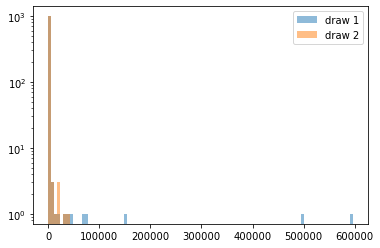

In [141]:
_, bins, _ = plt.hist(sample1, bins=100, alpha=.5, label='draw 1')
# we're reusing the bins determined from the first sample
plt.hist(sample2, bins=bins, alpha=.5, label='draw 2');
plt.yscale('log')
plt.legend()

 A common trick for both features and targets that follow a power law is to apply the log transform, which both makes scaling and plotting easier:

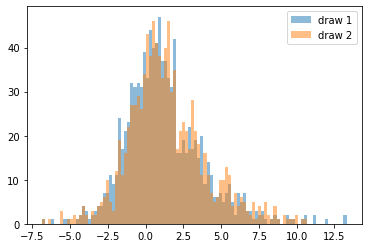

In [144]:
_, bins, _ = plt.hist(np.log(sample1), bins=100, alpha=.5, label='draw 1')
# we're reusing the bins determined from the first sample
plt.hist(np.log(sample2), bins=bins, alpha=.5, label='draw 2');
plt.legend()

Overall, there is no golden rule for determining the preprocessing, and often it is a good idea to evalute several alternatives, and use the one that results in the most accurate model.

## Thinking with Pipelines

Preprocessing your data is required in nearly every application, and the pattern we've seen in TODO is very common.
For that reason, scikit-learn has some tools to make your life easier, in particular the ``Pipeline`` class which allows you to chain preprocessing steps and models together.
Let's take a look at our example using the ``StandardScaler`` and ``KNeighborsClassifier`` on the breast cancer dataset:

In [146]:
# Scale the training data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Fit a knn model on the scaled data
knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)

# Scale the test data
X_test_scaled = scaler.transform(X_test)
print("accuracy with scaling: ", knn_scaled.score(X_test_scaled, y_test))

accuracy with scaling:  0.986013986013986


Using a ``Pipeline`` we can write this equivalently as:

In [147]:
from sklearn.pipeline import make_pipeline

# build a pipeline with two steps, the scaler and the classifier
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
# fit both steps on the training data:
pipe.fit(X_train, y_train)
# score the test dataset:
print("accuracy with scaling: ", pipe.score(X_test, y_test))

accuracy with scaling:  0.986013986013986


As you can see, we got the result, with much less code. Using pipelines allows you to encapsulate your whole processing workflow into a single Python object. This makes it much easier to avoid bugs, such as leaking information or forgetting to apply the same preprocessing steps to the test data that you applied to the training data.
In this instance we used ``make_pipeline`` which is a convenience function to create an object of the ``Pipeline`` class with very little code. The ``make_pipeline`` function takes an arbitrary number of arguments (I had passed two), which then become the *steps* of the pipeline.
I can equivalently create the same pipeline by directly using the ``Pipeline`` class. The ``Pipeline`` class takes a list of steps, each of which is specified as a tuple made out of a string and a scikit-learn model or preprocessor:

In [148]:
from sklearn.pipeline import Pipeline
# directly use the pipeline class
# A bunch more parenthesis here than when using make_pipeline
pipe2 = Pipeline([('scaler', StandardScaler()),
                  ('classifier', KNeighborsClassifier(n_neighbors=5))])

The string is the *name* of the step, which you can see when displaying the pipeline in Jupyter:

In [149]:
pipe2

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier())])

If you use the ``make_pipeline`` function, the names are assigned automatically, using the lower-cased class name:

In [151]:
# the pipeline we created using make_pipeline above
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])